In [2]:
import json
from collections import Counter
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import bipartite

## Book attributes

In [4]:
books_data = open("../data/goodreads_books_poetry.json")

Some attributes are excluded to reduce the size of information kept.

In [5]:
%%time

books = {}
excluded_attributes = ['popular_shelves', 'description', 'link', 'url', 'image_url']

for i, book in enumerate(books_data):
    data = json.loads(book)
    books[data['book_id']] = {attr: val for attr, val in data.items() if attr not in excluded_attributes}

CPU times: user 877 ms, sys: 54.7 ms, total: 932 ms
Wall time: 979 ms


In [6]:
# Should be 36 514
print(len(books))

36514


## User-book interactions

In [7]:
user_book_data = open("../data/goodreads_interactions_poetry.json")

In [8]:
%%time

links = []
user_ids = set()
book_ids = set()

for review in user_book_data:
    data = json.loads(review)

    u = data.get('user_id')
    user_ids.add(u)
    v = data.get('book_id')
    book_ids.add(v)
    attr = {'is_read': data.get('is_read'),
            'rating': data.get('rating')}
    link = {'u': u, 'v': v, 'attr': attr}
    links.append(link)

CPU times: user 9.33 s, sys: 399 ms, total: 9.73 s
Wall time: 10.1 s


In [9]:
# Should be 2 734 350
print(len(links))

2734350


In [10]:
print(links[0])

{'u': '8842281e1d1347389f2ab93d60773d4d', 'v': '1384', 'attr': {'is_read': True, 'rating': 4}}


## Attributed Bipartite Graph 

In [24]:
g = {}
g['V'] = {'left': list(user_ids), 'right': list(book_ids)}
g['E'] = links
g['A'] = {'left': None, 'right': books}

In [42]:
g['A']

{'left': None,
 'right': {'16037549': {'isbn': '',
   'text_reviews_count': '1',
   'series': [],
   'country_code': 'US',
   'language_code': 'eng',
   'asin': '',
   'is_ebook': 'false',
   'average_rating': '3.83',
   'kindle_asin': '',
   'similar_books': [],
   'format': 'Paperback',
   'authors': [{'author_id': '15585', 'role': ''}],
   'publisher': 'Houghton, Mifflin and Company',
   'num_pages': '80',
   'publication_day': '1',
   'isbn13': '',
   'publication_month': '11',
   'edition_information': '',
   'publication_year': '1887',
   'book_id': '16037549',
   'ratings_count': '3',
   'work_id': '5212748',
   'title': 'Vision of Sir Launfal and Other Poems',
   'title_without_series': 'Vision of Sir Launfal and Other Poems'},
  '22466716': {'isbn': '0811223981',
   'text_reviews_count': '2',
   'series': [],
   'country_code': 'US',
   'language_code': '',
   'asin': '',
   'is_ebook': 'false',
   'average_rating': '3.83',
   'kindle_asin': 'B00U2WY9U8',
   'similar_books': [

In [12]:
print(f"Number of users: {len(g['V']['left'])}")
print(f"Number of books: {len(g['V']['right'])}")
print(f"Number of reviews: {len(g['E'])}")

Number of users: 377799
Number of books: 36514
Number of reviews: 2734350


In [15]:
edges = [(elem.get('u'), elem.get('v')) for elem in g['E']]

G = nx.Graph()
# Add nodes
G.add_nodes_from(list(user_ids), bipartite=0)
G.add_nodes_from(list(book_ids), bipartite=1)
# Add edges
G.add_edges_from(edges)

In [20]:
print(len(books))

36514


### Degree distribution

In [34]:
def plot_distrib(dict_values, ax, xlabel='degree', log=True, title=None):
    values = [v for k, v in dict_values.items()]
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+')
    ax.legend()
    ax.set_title(title)
    if log and len(y) > 100:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


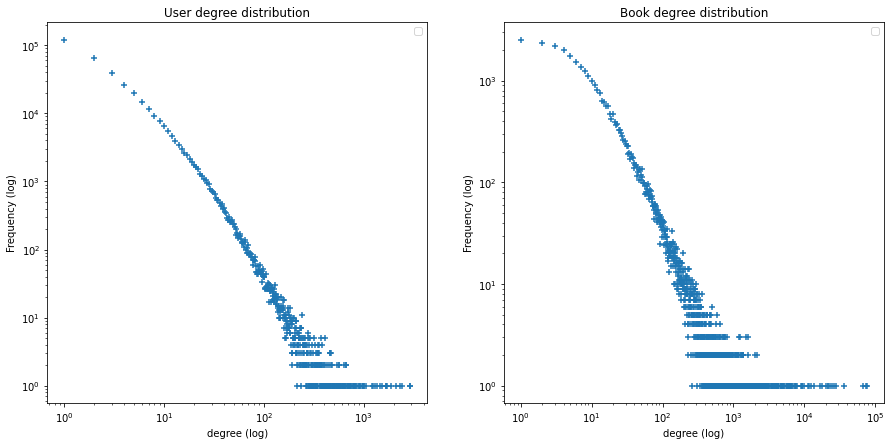

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plot_distrib(dict(G.degree(user_ids)), ax=ax[0], title='User degree distribution')
plot_distrib(dict(G.degree(book_ids)), ax=ax[1], title='Book degree distribution');

### Connected components

In [42]:
print(f'Graph is connected: {nx.is_connected(G)}')
print(f'Number of connected components: {nx.number_connected_components(G)}')
print(f'Size of connected components: {[len(i) for i in nx.connected_components(G)]}')

Graph is connected: False
Number of connected components: 105
Size of connected components: [414093, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [48]:
print(f'Density for users: {bipartite.density(G, user_ids):.7f}')
print(f'Density for books: {bipartite.density(G, book_ids):.7f}')

Density for users: 0.0001982
Density for books: 0.0001982


In [43]:
g['E'][0]

{'u': '8842281e1d1347389f2ab93d60773d4d',
 'v': '1384',
 'attr': {'is_read': True, 'rating': 4}}